In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np

In [2]:
from batchglm.api.models.nb_glm import Simulator
import diffxpy.api as de

In [3]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

# Generate some data:

In [4]:
sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=4)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

X = sim.X
sample_description = sim.sample_description

In [5]:
sample_description.iloc[:10,:]

,condition
observations,
0,0
1,1
2,2
3,3
4,0
5,1
6,2
7,3
8,0


# Test entire factor

In [6]:
test_fac = de.test.wald(
    data=X,
    formula="~ 1 + condition",
    factor_loc_totest="condition",
    sample_description=sample_description,
    training_strategy="QUICK",
    dtype="float64"
)

Fitting model...
Using closed-form MLE initialization for mean
Should train mu: False
Using closed-form MME initialization for dispersion
Should train r: True


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.1,
  'loss_window_size': 100,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.05,
  'use_batching': True}]
Beginning with training sequence #1
Training sequence #1 complete


In [7]:
test_fac.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,grad,ll
0,0,1.130649e-04,1.413312e-04,-0.089716,1450.2695,0.088973,-16272.817377
1,1,1.438065e-03,1.652948e-03,0.047177,5241.0785,0.254513,-18173.666944
2,2,7.904788e-14,1.613222e-13,0.131362,8880.5740,0.344120,-18683.263588
3,3,0.000000e+00,0.000000e+00,0.203520,3364.4980,0.370090,-17279.729955
4,4,2.658027e-03,2.986547e-03,0.080100,3611.8310,0.225549,-17732.856296
5,5,0.000000e+00,0.000000e+00,-0.150252,8373.6875,0.147828,-19362.122372
6,6,8.563790e-06,1.097922e-05,0.070900,2921.2115,0.226419,-16601.605564
7,7,0.000000e+00,0.000000e+00,-0.307544,2428.1185,0.213961,-16452.120689
8,8,7.184174e-08,1.026311e-07,0.093078,4720.9795,0.200336,-18048.786422
9,9,2.702694e-11,4.826239e-11,0.120976,5991.9805,0.194962,-18707.956805


In [8]:
test_fac.theta_sd.shape

(100, 8)

The volcano plot looks a bit weird because only the maximal coefficient is shown, the pvalue comes from a test which is base on the full set of coefficients though.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c311f1c50>)

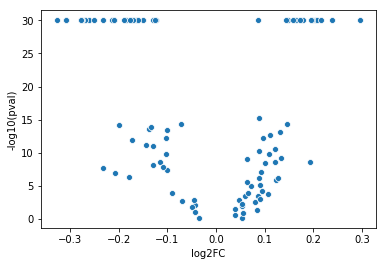

In [9]:
test_fac.plot_volcano()

# Test specific coefficients

Check coefficient names in model by pre-genereating design matrix from sample description (the corresponding function is provided through diffxpy and provides the same design matrix as is later used within the test):

In [10]:
de.test.coef_names(data = X, sample_description=sample_description, formula="~ 1 + condition")

['Intercept', 'condition[T.1]', 'condition[T.2]', 'condition[T.3]']

Run test on all coefficients related to condition (i.e. all three condition effects, the fourth one is absorbed into the intercept):

In [11]:
test_coef = de.test.wald(
    data=X,
    formula="~ 1 + condition",
    coef_to_test=['condition[T.1]', 'condition[T.2]', 'condition[T.3]'],
    sample_description=sample_description,
    training_strategy="QUICK",
    dtype="float64"
)

Fitting model...
Using closed-form MLE initialization for mean
Should train mu: False
Using closed-form MME initialization for dispersion
Should train r: True


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.1,
  'loss_window_size': 100,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.05,
  'use_batching': True}]
Beginning with training sequence #1
Training sequence #1 complete


In [12]:
test_coef.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,grad,ll
0,0,1.005083e-04,1.256354e-04,-0.089716,1450.2695,0.205537,-16273.168788
1,1,7.979014e-04,9.387076e-04,0.047177,5241.0785,0.124232,-18173.203094
2,2,4.019007e-14,8.372932e-14,0.131362,8880.5740,0.469860,-18684.028009
3,3,0.000000e+00,0.000000e+00,0.203520,3364.4980,0.240819,-17278.673740
4,4,3.082826e-03,3.463850e-03,0.080100,3611.8310,0.230863,-17733.140070
5,5,0.000000e+00,0.000000e+00,-0.150252,8373.6875,0.235287,-19362.988023
6,6,3.197547e-06,4.207298e-06,0.070900,2921.2115,0.169612,-16601.772086
7,7,0.000000e+00,0.000000e+00,-0.307544,2428.1185,0.289185,-16450.619625
8,8,4.602300e-08,6.669999e-08,0.093078,4720.9795,0.279850,-18048.207604
9,9,4.067735e-11,7.013336e-11,0.120976,5991.9805,0.268470,-18707.221582


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c335e5d30>)

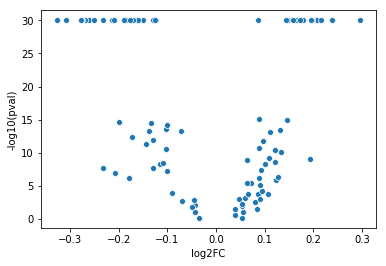

In [13]:
test_coef.plot_volcano()

# Compare results

The factor and coefficient wise test should be the same, they are two input options to phrase the exact same test.

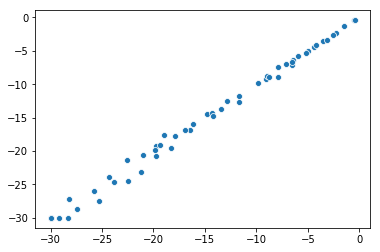

In [14]:
test_fac_pval = np.log(test_fac.pval)
test_fac_pval[test_fac_pval < -30] = -30
test_coef_pval = np.log(test_coef.pval)
test_coef_pval[test_coef_pval < -30] = -30
sns.scatterplot(test_fac_pval, test_coef_pval)